# Tennis Action Evaluator

## Introduction

### Problem

### Model Definition

#### State

#### Action

#### Rewards

### Data Processing

#### Raw Data

#### Extracted data

### Evaluation

We evaluate the model based on how well it estimates the actual probability that the agent at state $s$ performing action $a$ will win the rally.

We do this by passing a list of $(s,a)$ pairs to the estimator model to get the $Q(s,a)$ indicating the probability of the agent winning. Each $(s,a)$ pair has already been marked as belonging to the winner or the loser of the rally.

We deem a prediction correct in the following cases:
1. The $(s,a)$ pair belongs to the winner and gives a $Q(s,a) \ge 0.5$ 
2. The $(s,a)$ pair belongs to the loser and gives a $Q(s,a) \lt 0.5$

The final score of the model is calculated using $\frac{\text{correct predictions}}{\text{total predictions}}$.

## Approximated MC Learning

First, we tried a simple approximated MC learning to approximate the $Q(s,a)$ function as a baseline. This is a simple linear regression problem. We used `sklearn.linear_model.LinearRegression` to create an estimator model.

Since the reward of a tennis rally is only non-zero at the end of a rally, MC learning's behavior of looking at the accumulated rewards for an entire trial might be beneficial for estimating the Q-values of tennis actions.

### Training

Being that it is merely solving a system of linear equations, training of the estimator model is very quick for approximated MC learning.

In [1]:
import mc_learning as mc

mc_model = mc.train(save=False)
print(mc_model.coef_)

[[ 0.00046365  0.00620755  0.00934649 -0.02493163  0.0050135  -0.02148365
  -0.00191497 -0.00411411 -0.00643848  0.0220249  -0.00568214  0.02426598
   0.00129729 -0.00062967 -0.02203004  0.00634108 -0.00288176]]


### Evaluation

However, accuracy is low for this method, only correctly predicting the outcome of the $Q(s,a)$ correctly 53% of the time. The $Q(s,a)$ cannot be directly represented by a linear function of the features we have defined.

In [2]:
from data import test_dataset
import evaluation as eval

def mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = mc_model.predict(single_sample_reshape)
    return pred

score = eval.score_model(test_dataset, mc_predict)

print(f"Linear MC Learning Accuracy: {score}")

Linear MC Learning Accuracy: (0.5361596009975063, 0.24950967844844793)


## Deep Reinforcement Learning

### MC

#### Training

In [3]:
import d_sarsa

nn_mc_model, nn_mc_report = d_sarsa.train(save=False, use_mc=True)

EPOCH: 1.000  train_ave_loss: 0.254  train_ave_acc: 0.540  (3.03s - 299.79s remaining) ave_loss: 0.2536957601298335 ave_acc: 0.5396838021519443
EPOCH: 2.000  train_ave_loss: 0.240  train_ave_acc: 0.600  (5.86s - 287.16s remaining) ave_loss: 0.24030891290245868 ave_acc: 0.6003885787325813
EPOCH: 3.000  train_ave_loss: 0.237  train_ave_acc: 0.628  (8.67s - 280.32s remaining) ave_loss: 0.23703918378811079 ave_acc: 0.6275226826183976
EPOCH: 4.000  train_ave_loss: 0.232  train_ave_acc: 0.620  (11.46s - 275.03s remaining) ave_loss: 0.23200933949863456 ave_acc: 0.6204116221459559
EPOCH: 5.000  train_ave_loss: 0.231  train_ave_acc: 0.634  (14.25s - 270.66s remaining) ave_loss: 0.23122910117386372 ave_acc: 0.63393768863407
EPOCH: 6.000  train_ave_loss: 0.228  train_ave_acc: 0.632  (17.07s - 267.42s remaining) ave_loss: 0.2282696924338942 ave_acc: 0.6323109926926986
EPOCH: 7.000  train_ave_loss: 0.227  train_ave_acc: 0.639  (19.87s - 264.00s remaining) ave_loss: 0.22686078242651703 ave_acc: 0.63

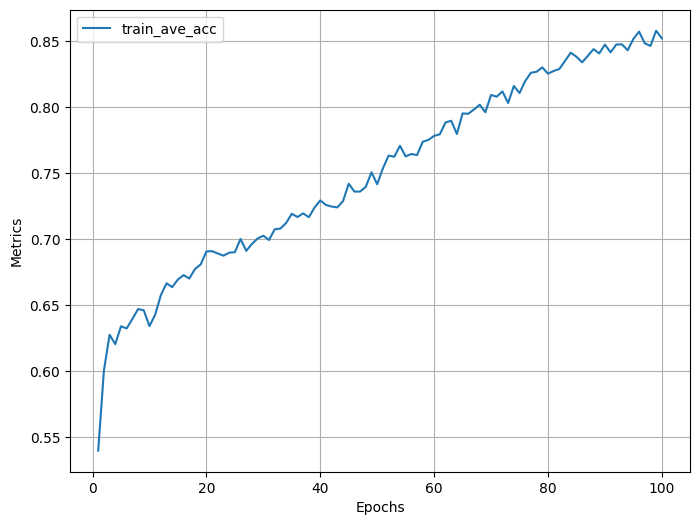

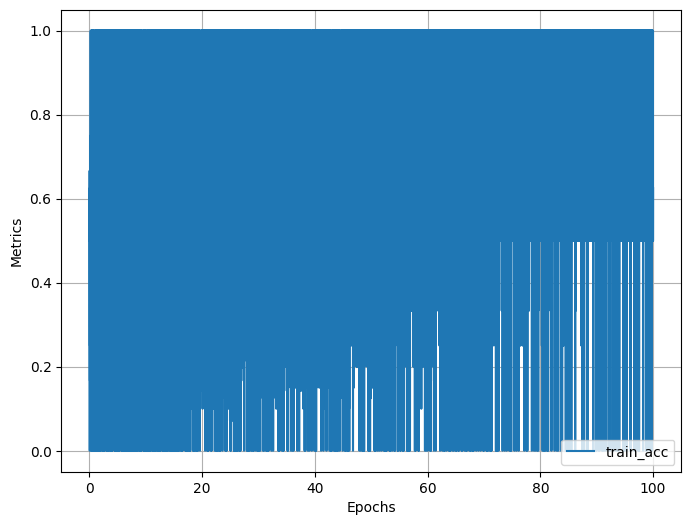

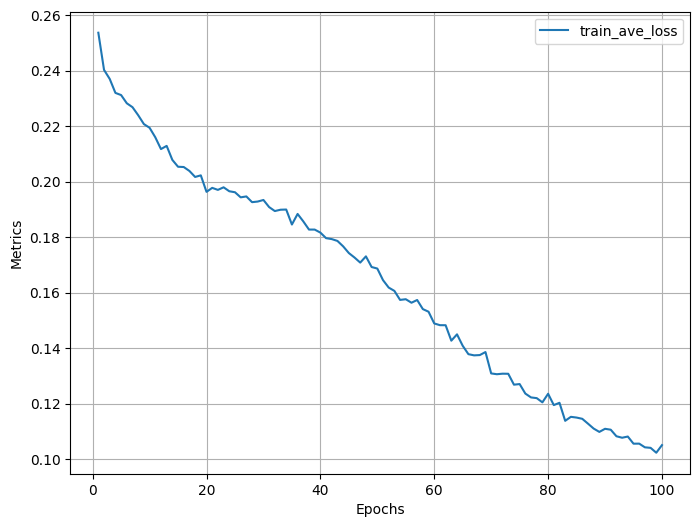

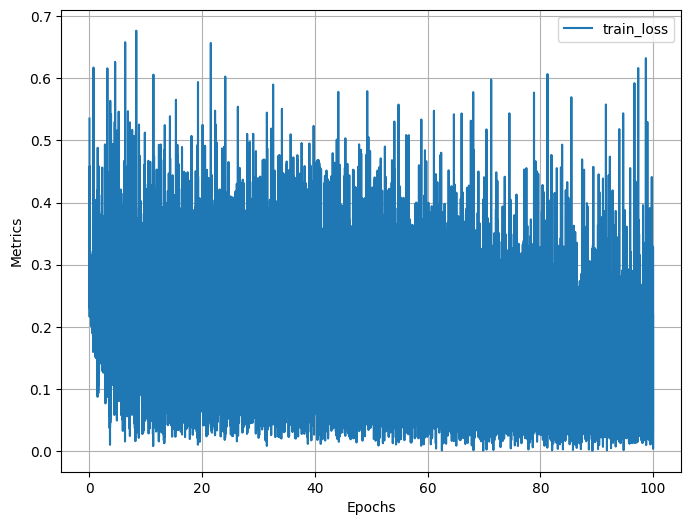

In [4]:
nn_mc_report.plot('train_ave_acc')
nn_mc_report.plot('train_acc')
nn_mc_report.plot('train_ave_loss')
nn_mc_report.plot('train_loss')

#### Evaluation

In [5]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_mc_model.eval()
def nn_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_mc_score, nn_mc_mse = eval.score_model(test_dataset, nn_mc_predict)

def nn_mc_predict_seq(sa_pair_seq):
    pred = nn_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_mc_seq_score, nn_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_mc_predict_seq)

print(f"NN MC Accuracy: {nn_mc_score}")
print(f"NN MC MSE: {nn_mc_mse}")
print(f"NN MC Seq Accuracy: {nn_mc_seq_score}")
print(f"NN MC Seq MSE: {nn_mc_seq_mse}")

NN MC Accuracy: 0.5635910224438903
NN MC MSE: 0.31445617919156565
NN MC Seq Accuracy: 0.6246882793017456
NN MC Seq MSE: 0.2760081757260401


### SARSA

#### Training (Without MC Init)

In [6]:
import d_sarsa

nn_sarsa_model, nn_sarsa_report = d_sarsa.train(save=False, use_mc=False)

EPOCH: 1.000  train_ave_loss: 0.160  train_ave_acc: 0.507  (2.59s - 256.26s remaining) ave_loss: 0.15978953340077157 ave_acc: 0.5069526893593108
EPOCH: 2.000  train_ave_loss: 0.128  train_ave_acc: 0.538  (5.21s - 255.15s remaining) ave_loss: 0.12825505434920537 ave_acc: 0.5382806946689241
EPOCH: 3.000  train_ave_loss: 0.124  train_ave_acc: 0.547  (7.80s - 252.10s remaining) ave_loss: 0.12440898567656618 ave_acc: 0.5466138080472518
EPOCH: 4.000  train_ave_loss: 0.120  train_ave_acc: 0.570  (10.39s - 249.30s remaining) ave_loss: 0.11974407887616116 ave_acc: 0.5698374780156306
EPOCH: 5.000  train_ave_loss: 0.123  train_ave_acc: 0.552  (12.95s - 246.07s remaining) ave_loss: 0.12332630798198785 ave_acc: 0.5523344810863768
EPOCH: 6.000  train_ave_loss: 0.120  train_ave_acc: 0.556  (15.50s - 242.83s remaining) ave_loss: 0.12036364296139859 ave_acc: 0.5562149106056918
EPOCH: 7.000  train_ave_loss: 0.102  train_ave_acc: 0.567  (18.07s - 240.05s remaining) ave_loss: 0.1015655878860274 ave_acc: 0

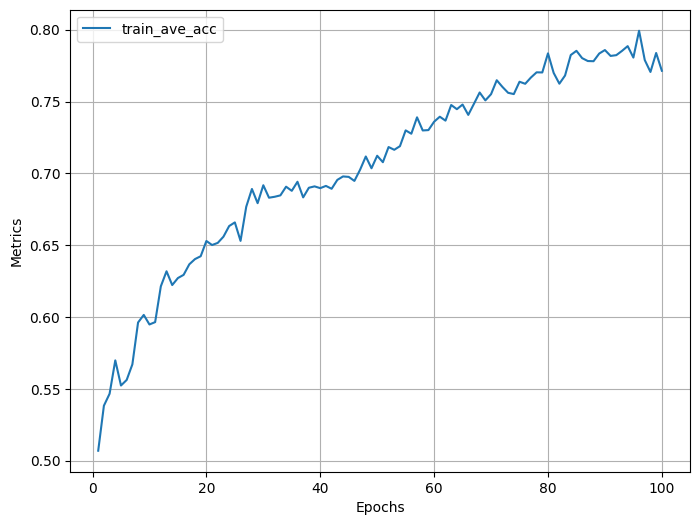

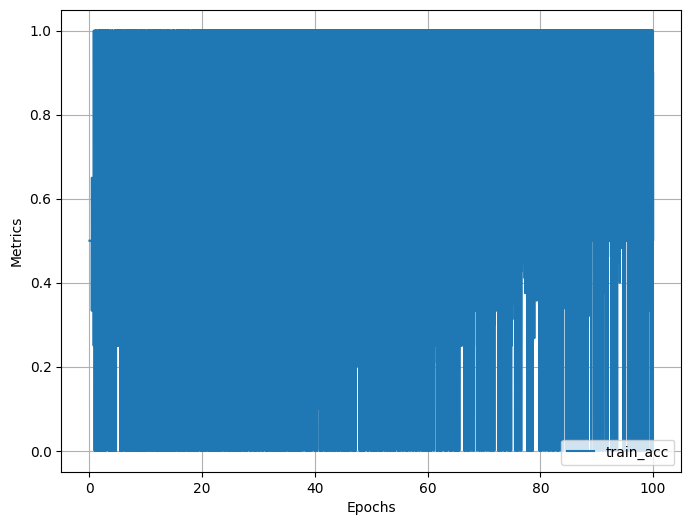

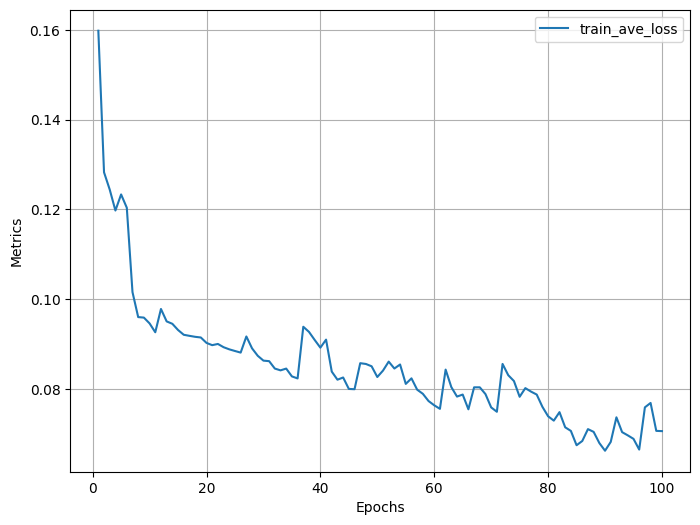

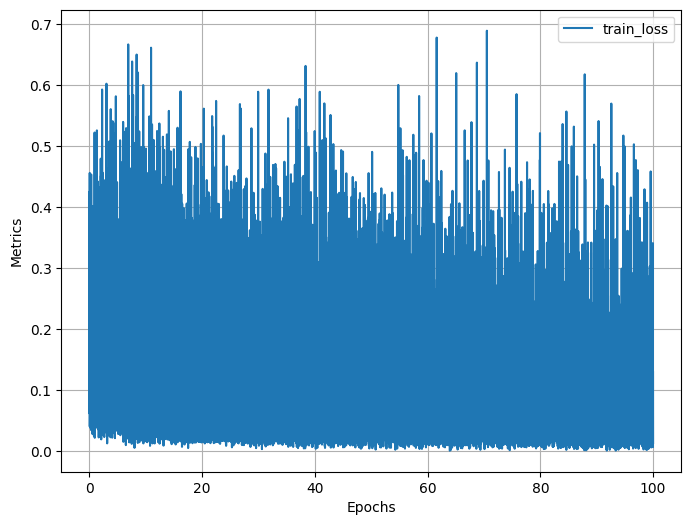

In [7]:
nn_sarsa_report.plot('train_ave_acc')
nn_sarsa_report.plot('train_acc')
nn_sarsa_report.plot('train_ave_loss')
nn_sarsa_report.plot('train_loss')

#### Evaluation (Without MC Init)

In [8]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_model.eval()
def nn_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_score, nn_sarsa_mse = eval.score_model(test_dataset, nn_predict)

def nn_predict_seq(sa_pair_seq):
    pred = nn_sarsa_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_seq_score, nn_sarsa_seq_mse = eval.score_model_sequential(test_dataset, nn_predict_seq)

print(f"NN Sarsa Accuracy: {nn_sarsa_score}")
print(f"NN Sarsa MSE: {nn_sarsa_mse}")
print(f"NN Sarsa Seq Accuracy: {nn_sarsa_seq_score}")
print(f"NN Sarsa Seq MSE: {nn_sarsa_seq_mse}")

NN Sarsa Accuracy: 0.5423940149625935
NN Sarsa MSE: 0.2982259326541935
NN Sarsa Seq Accuracy: 0.5748129675810474
NN Sarsa Seq MSE: 0.29066246424187014


#### Training (With MC Init)

In [9]:
import d_sarsa

nn_mc_state_dict = nn_mc_model.state_dict()
nn_sarsa_with_mc_model, nn_sarsa_with_mc_report = d_sarsa.train(save=False, use_mc=False, init_state_dict=nn_mc_state_dict)

Init state dictionary was passed. Using that to initialize model_net.
EPOCH: 1.000  train_ave_loss: 0.087  train_ave_acc: 0.835  (2.72s - 269.52s remaining) ave_loss: 0.08703909554079044 ave_acc: 0.8348602265098216
EPOCH: 2.000  train_ave_loss: 0.086  train_ave_acc: 0.817  (5.45s - 266.94s remaining) ave_loss: 0.08624065650252849 ave_acc: 0.8166753740913247
EPOCH: 3.000  train_ave_loss: 0.079  train_ave_acc: 0.813  (8.18s - 264.49s remaining) ave_loss: 0.07945850424064307 ave_acc: 0.8128358351510757
EPOCH: 4.000  train_ave_loss: 0.075  train_ave_acc: 0.810  (10.89s - 261.29s remaining) ave_loss: 0.07493430710891999 ave_acc: 0.8097422513935829
EPOCH: 5.000  train_ave_loss: 0.073  train_ave_acc: 0.811  (13.59s - 258.20s remaining) ave_loss: 0.07311455402052155 ave_acc: 0.8109396265666203
EPOCH: 6.000  train_ave_loss: 0.072  train_ave_acc: 0.808  (16.31s - 255.58s remaining) ave_loss: 0.07245571193725002 ave_acc: 0.8083247984789855
EPOCH: 7.000  train_ave_loss: 0.075  train_ave_acc: 0.803

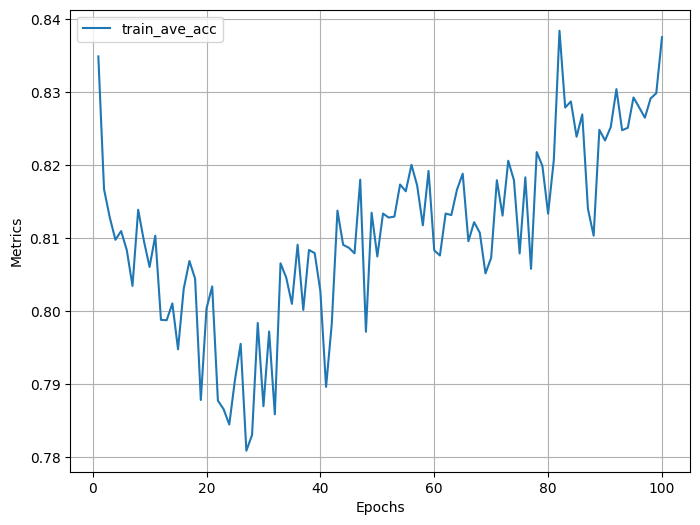

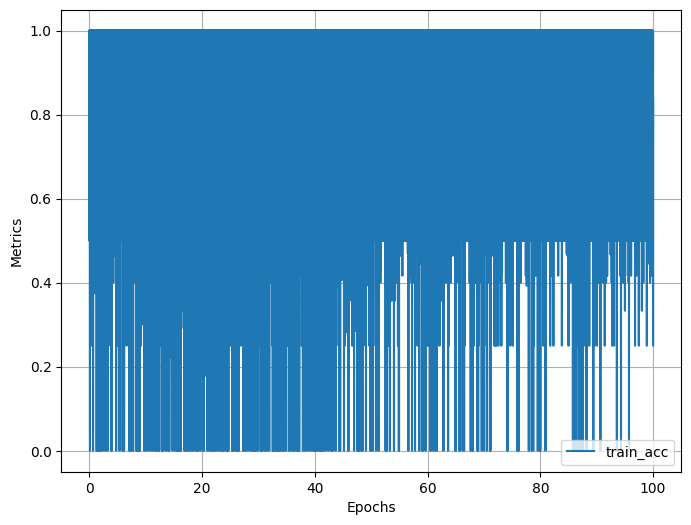

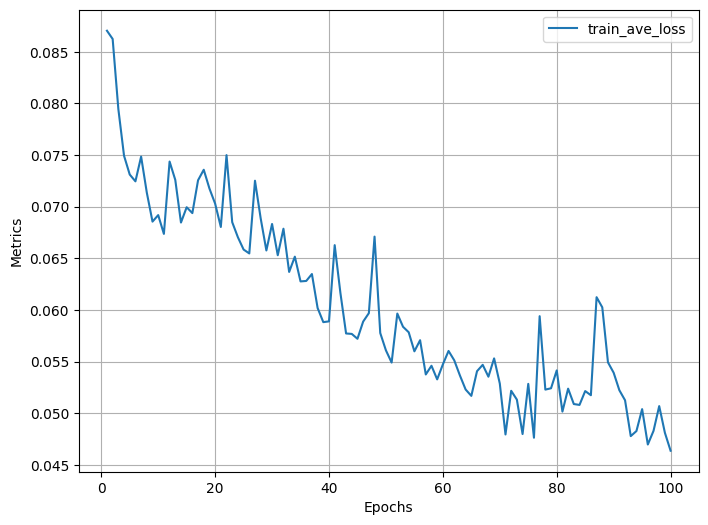

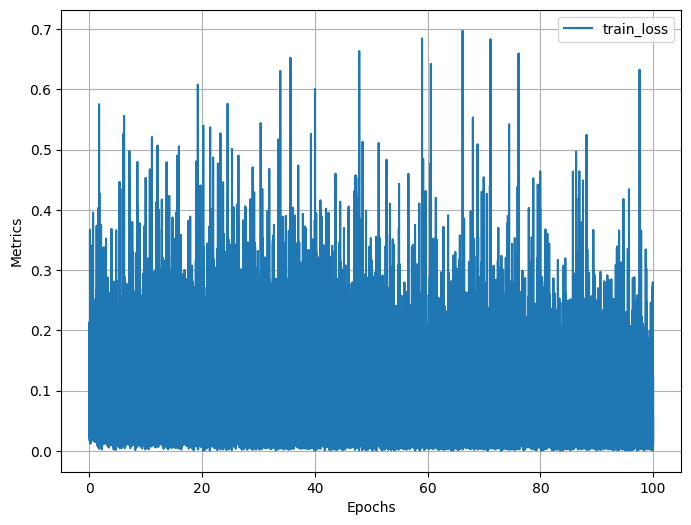

In [10]:
nn_sarsa_with_mc_report.plot('train_ave_acc')
nn_sarsa_with_mc_report.plot('train_acc')
nn_sarsa_with_mc_report.plot('train_ave_loss')
nn_sarsa_with_mc_report.plot('train_loss')

#### Evaluation (With MC Init)

In [11]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_with_mc_model.eval()
def nn_sarsa_with_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_with_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_with_mc_score, nn_sarsa_with_mc_mse = eval.score_model(test_dataset, nn_sarsa_with_mc_predict)

def nn_sarsa_with_mc_predict_seq(sa_pair_seq):
    pred = nn_sarsa_with_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_with_mc_seq_score, nn_sarsa_with_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_sarsa_with_mc_predict_seq)

print(f"NN Sarsa With MC Init Accuracy: {nn_sarsa_with_mc_score}")
print(f"NN Sarsa With MC Init MSE: {nn_sarsa_with_mc_mse}")
print(f"NN Sarsa With MC Init Seq Accuracy: {nn_sarsa_with_mc_seq_score}")
print(f"NN Sarsa With MC Init Seq MSE: {nn_sarsa_with_mc_seq_mse}")

NN Sarsa With MC Init Accuracy: 0.5399002493765586
NN Sarsa With MC Init MSE: 0.31720963691026244
NN Sarsa With MC Init Seq Accuracy: 0.5960099750623441
NN Sarsa With MC Init Seq MSE: 0.28117144577673


In [12]:
import os

model_dirpath = 'experiment_models/100epoch_vanilla_paper_params'
os.makedirs(model_dirpath, exist_ok=True)


torch.save(nn_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_mc_model.pth'))
torch.save(nn_sarsa_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_model.pth'))
torch.save(nn_sarsa_with_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_with_mc_model.pth'))

## Conclusion

### Summary

### Future extensions